# PART 1: SETUP AND INSTALLATIONS

In [13]:
!pip install librosa soundfile gtts pydub -q

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import lfilter
import os
from gtts import gTTS
from pydub import AudioSegment
from pydub.playback import play
import warnings
warnings.filterwarnings('ignore')

print("Libraries installed successfully!")

Libraries installed successfully!


# PART 2: TEXT-TO-SPEECH CONVERSION (Generate Audio from Text)

In [2]:
def create_voice_commands():
    commands = [
        "Turn on the lights",
        "Play music",
        "Set thermostat to 25 degrees"
    ]

    os.makedirs('voice_commands', exist_ok=True)

    audio_files = []
    for i, command in enumerate(commands):
        filename = f'voice_commands/command_{i+1}.wav'

        tts = gTTS(text=command, lang='en', slow=False)
        temp_file = f'voice_commands/temp_{i+1}.mp3'
        tts.save(temp_file)

        audio = AudioSegment.from_mp3(temp_file)
        audio = audio.set_frame_rate(22050)
        audio.export(filename, format='wav')

        audio_files.append(filename)
        print(f"Created: {command} -> {filename}")

        os.remove(temp_file)

    return audio_files, commands

print("\n=== Generating Voice Commands ===")
audio_files, command_texts = create_voice_commands()


=== Generating Voice Commands ===
Created: Turn on the lights -> voice_commands/command_1.wav
Created: Play music -> voice_commands/command_2.wav
Created: Set thermostat to 25 degrees -> voice_commands/command_3.wav


# PART 3: NOISE REDUCTION - PRE-EMPHASIS FILTER

In [3]:
def apply_preemphasis(signal, coef=0.97):
    return lfilter([1, -coef], [1], signal)

def add_background_noise(signal, sr, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented = signal + noise_factor * noise
    return augmented

# PART 4: FEATURE EXTRACTION - MFCC


=== Extracting MFCC Features ===
MFCC shape: (13, 80)
Number of frames: 80


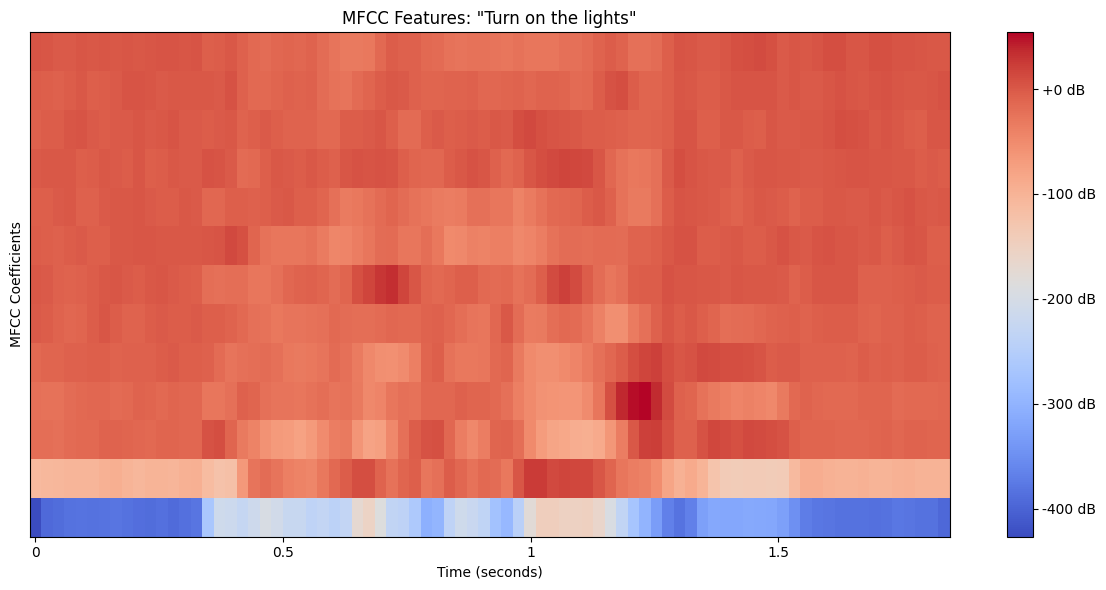


=== Comparing Noise Reduction Effect ===


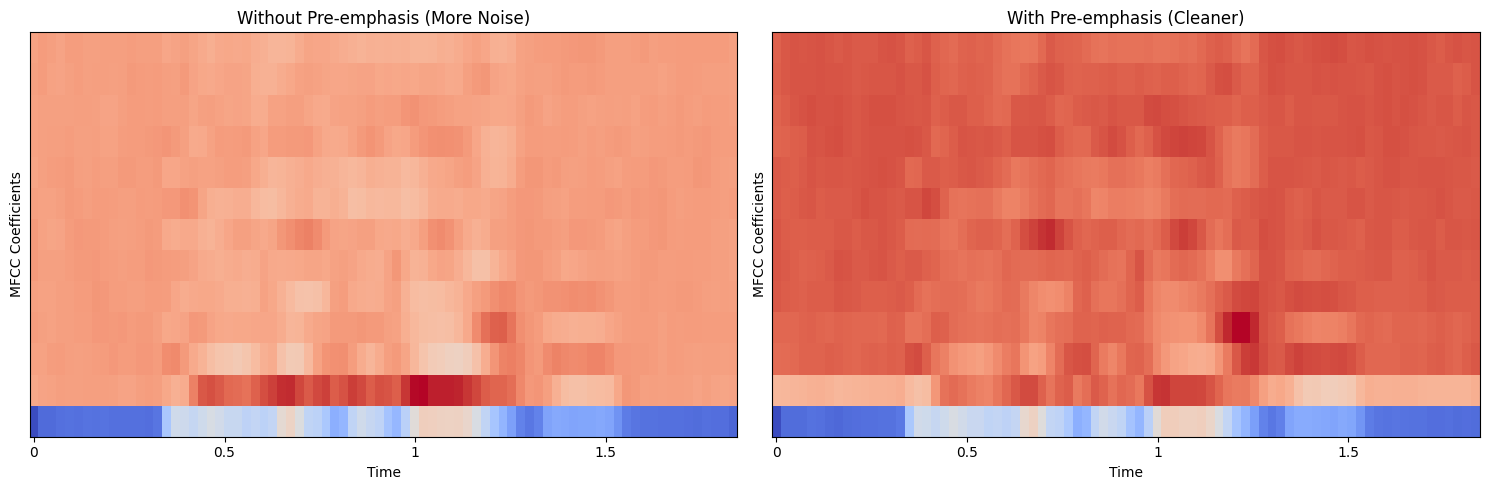

In [4]:
def extract_mfcc_features(audio_file, n_mfcc=13, apply_noise_reduction=True):

    signal, sr = librosa.load(audio_file, sr=22050)

    noisy_signal = add_background_noise(signal, sr)

    if apply_noise_reduction:
        processed_signal = apply_preemphasis(noisy_signal)
    else:
        processed_signal = noisy_signal

    mfcc_features = librosa.feature.mfcc(
        y=processed_signal,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=2048,
        hop_length=512
    )

    return mfcc_features, sr, processed_signal

def plot_mfcc_features(mfcc_features, sr, command_text, save_path=None):

    plt.figure(figsize=(12, 6))

    librosa.display.specshow(
        mfcc_features,
        x_axis='time',
        sr=sr,
        hop_length=512
    )

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Features: "{command_text}"')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

print("\n=== Extracting MFCC Features ===")
mfcc_features, sr, signal = extract_mfcc_features(audio_files[0])
print(f"MFCC shape: {mfcc_features.shape}")
print(f"Number of frames: {mfcc_features.shape[1]}")

plot_mfcc_features(mfcc_features, sr, command_texts[0], 'mfcc_plot.png')

print("\n=== Comparing Noise Reduction Effect ===")
mfcc_no_reduction, _, _ = extract_mfcc_features(audio_files[0], apply_noise_reduction=False)
mfcc_with_reduction, _, _ = extract_mfcc_features(audio_files[0], apply_noise_reduction=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

librosa.display.specshow(mfcc_no_reduction, x_axis='time', sr=sr, ax=axes[0])
axes[0].set_title('Without Pre-emphasis (More Noise)')
axes[0].set_ylabel('MFCC Coefficients')

librosa.display.specshow(mfcc_with_reduction, x_axis='time', sr=sr, ax=axes[1])
axes[1].set_title('With Pre-emphasis (Cleaner)')
axes[1].set_ylabel('MFCC Coefficients')

plt.tight_layout()
plt.savefig('noise_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# PART 5: VITERBI ALGORITHM FOR HMM DECODING

In [5]:
class ViterbiDecoder:

    def __init__(self, states, observations):
        self.states = states
        self.observations = observations
        self.n_states = len(states)

    def set_probabilities(self, start_prob, trans_prob, emit_prob):
        self.start_prob = start_prob
        self.trans_prob = trans_prob
        self.emit_prob = emit_prob

    def decode(self, observations):

        n_obs = len(observations)

        # Initialize Viterbi matrix and path matrix
        viterbi = np.zeros((self.n_states, n_obs))
        path = np.zeros((self.n_states, n_obs), dtype=int)

        # Initialization step (t=0)
        for s in range(self.n_states):
            viterbi[s, 0] = self.start_prob[s] * self.emit_prob[s, observations[0]]
            path[s, 0] = 0

        # Recursion step (t=1 to n_obs-1)
        for t in range(1, n_obs):
            for s in range(self.n_states):
                # Find maximum probability and best previous state
                trans_probs = viterbi[:, t-1] * self.trans_prob[:, s]
                path[s, t] = np.argmax(trans_probs)
                viterbi[s, t] = np.max(trans_probs) * self.emit_prob[s, observations[t]]

        # Termination step
        best_last_state = np.argmax(viterbi[:, -1])
        max_prob = viterbi[best_last_state, -1]

        # Backtrack to find best path
        best_path = np.zeros(n_obs, dtype=int)
        best_path[-1] = best_last_state

        for t in range(n_obs-2, -1, -1):
            best_path[t] = path[best_path[t+1], t+1]

        return best_path, max_prob

# PART 6: SIMPLIFIED HMM SETUP

In [6]:
phoneme_states = ['T', 'ER', 'N', 'AO', 'N_end', 'DH', 'AH', 'L', 'AY', 'T_s']
n_states = len(phoneme_states)

def quantize_observations(mfcc_features, n_clusters=5):
    from sklearn.cluster import KMeans

    features_transposed = mfcc_features.T

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    observation_seq = kmeans.fit_predict(features_transposed)

    return observation_seq

print("\n=== Quantizing MFCC Features ===")
observation_sequence = quantize_observations(mfcc_features, n_clusters=5)
print(f"Observation sequence length: {len(observation_sequence)}")
print(f"Observation sequence: {observation_sequence[:20]}...")

start_prob = np.array([0.3, 0.1, 0.1, 0.1, 0.05, 0.1, 0.1, 0.05, 0.05, 0.05])

trans_prob = np.random.rand(n_states, n_states)
trans_prob = trans_prob / trans_prob.sum(axis=1, keepdims=True)
for i in range(n_states):
    trans_prob[i, :] *= 0.1
    if i < n_states - 1:
        trans_prob[i, i] = 0.4
        trans_prob[i, i+1] = 0.4

n_observations = 5
emit_prob = np.random.rand(n_states, n_observations)
emit_prob = emit_prob / emit_prob.sum(axis=1, keepdims=True)  # Normalize

print("\n=== HMM Probability Matrices ===")
print(f"Start probabilities shape: {start_prob.shape}")
print(f"Transition probabilities shape: {trans_prob.shape}")
print(f"Emission probabilities shape: {emit_prob.shape}")


=== Quantizing MFCC Features ===
Observation sequence length: 80
Observation sequence: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 4 4]...

=== HMM Probability Matrices ===
Start probabilities shape: (10,)
Transition probabilities shape: (10, 10)
Emission probabilities shape: (10, 5)


# PART 7: VITERBI DECODING

In [7]:
print("\n=== Running Viterbi Algorithm ===")

# Initialize decoder
decoder = ViterbiDecoder(phoneme_states, range(n_observations))
decoder.set_probabilities(start_prob, trans_prob, emit_prob)

# Decode the observation sequence
best_path, probability = decoder.decode(observation_sequence)

# Convert state indices to phoneme labels
decoded_phonemes = [phoneme_states[state] for state in best_path]

print(f"\nDecoded Phoneme Sequence:")
print(" -> ".join(decoded_phonemes[:15]), "...")
print(f"\nSequence Probability: {probability:.2e}")
print(f"\nLog Probability: {np.log10(probability):.2f}")


=== Running Viterbi Algorithm ===

Decoded Phoneme Sequence:
T -> T -> T -> T -> T -> T -> T -> T -> T -> T -> T -> T -> T -> T -> T ...

Sequence Probability: 4.54e-72

Log Probability: -71.34


# PART 8: ANALYSIS AND VISUALIZATION


=== DECODING ANALYSIS ===
Command: 'Turn on the lights'
Total frames analyzed: 80
Unique phonemes in sequence: 9


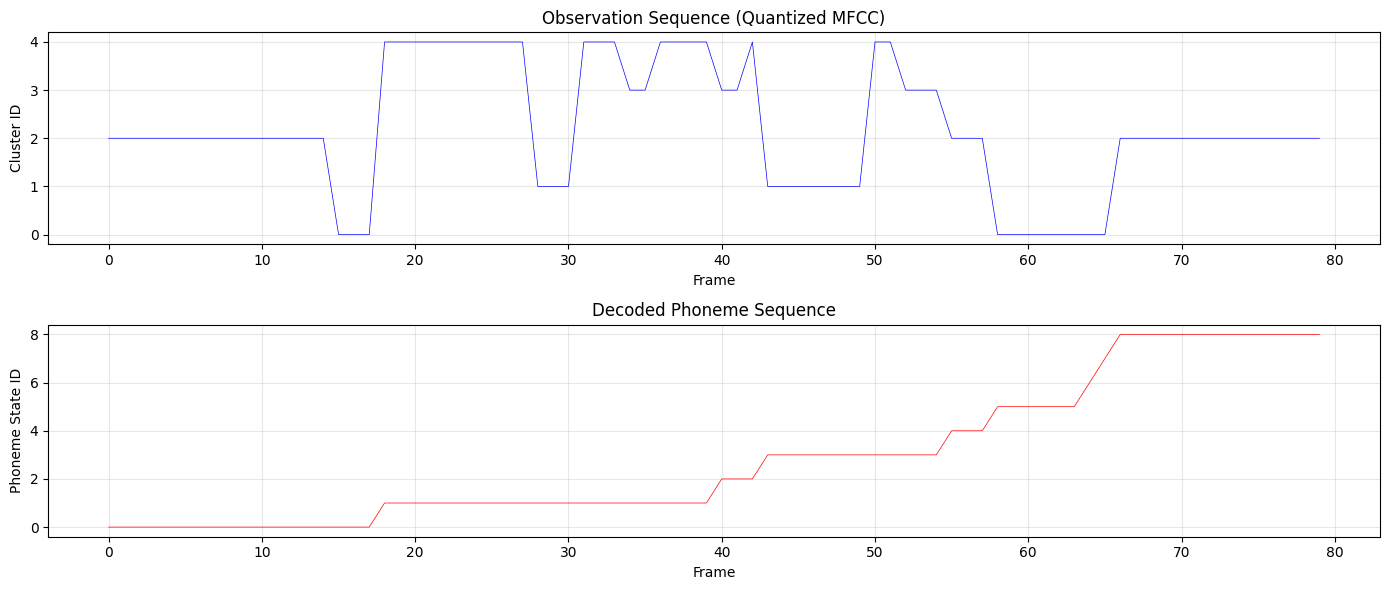

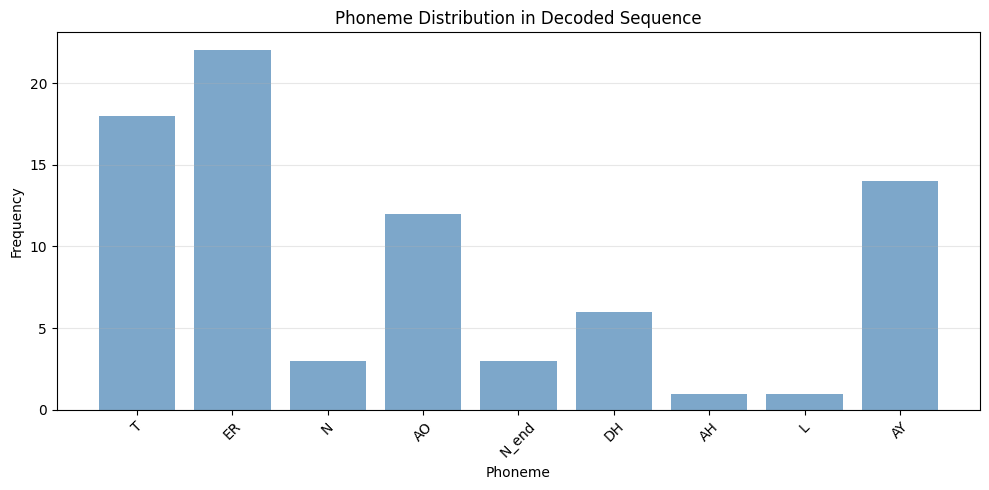

In [8]:
def analyze_decoding_results(decoded_path, observation_seq, command_text):
    """
    Analyze and visualize decoding results
    """
    print("\n=== DECODING ANALYSIS ===")
    print(f"Command: '{command_text}'")
    print(f"Total frames analyzed: {len(observation_seq)}")
    print(f"Unique phonemes in sequence: {len(set(decoded_path))}")

    plt.figure(figsize=(14, 6))

    plt.subplot(2, 1, 1)
    plt.plot(observation_seq, 'b-', linewidth=0.5)
    plt.title('Observation Sequence (Quantized MFCC)')
    plt.xlabel('Frame')
    plt.ylabel('Cluster ID')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(decoded_path, 'r-', linewidth=0.5)
    plt.title('Decoded Phoneme Sequence')
    plt.xlabel('Frame')
    plt.ylabel('Phoneme State ID')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('decoding_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    unique_phonemes, counts = np.unique(decoded_path, return_counts=True)

    plt.figure(figsize=(10, 5))
    phoneme_labels = [phoneme_states[p] for p in unique_phonemes]
    plt.bar(phoneme_labels, counts, color='steelblue', alpha=0.7)
    plt.title('Phoneme Distribution in Decoded Sequence')
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('phoneme_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

analyze_decoding_results(best_path, observation_sequence, command_texts[0])

# PART 9: TESTING WITH ALL COMMANDS

In [12]:
print("\n" + "="*70)
print("TESTING ALL VOICE COMMANDS")
print("="*70)

all_results = []

for i, (audio_file, command) in enumerate(zip(audio_files, command_texts)):
    print(f"\n--- Command {i+1}: '{command}' ---")

    mfcc, sr, _ = extract_mfcc_features(audio_file)

    obs_seq = quantize_observations(mfcc, n_clusters=5)

    path, prob = decoder.decode(obs_seq)
    phonemes = [phoneme_states[s] for s in path]

    print(f"Frames: {len(obs_seq)}")
    print(f"Decoded phonemes: {' -> '.join(phonemes[:10])}...")
    print(f"Probability: {prob:.2e}")

    all_results.append({
        'command': command,
        'frames': len(obs_seq),
        'phonemes': phonemes,
        'probability': prob
    })


TESTING ALL VOICE COMMANDS

--- Command 1: 'Turn on the lights' ---
Frames: 80
Decoded phonemes: AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH...
Probability: 4.27e-77

--- Command 2: 'Play music' ---
Frames: 57
Decoded phonemes: AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH -> AH...
Probability: 2.90e-55

--- Command 3: 'Set thermostat to 25 degrees' ---
Frames: 143
Decoded phonemes: T -> T -> T -> T -> T -> T -> T -> T -> T -> T...
Probability: 1.18e-133
